# 🎯 Telco Customer Churn - Production Prediction Interface

This notebook creates a production-ready prediction interface for the churn prediction model.

**Objectives**:
- Load trained model and preprocessing components
- Create prediction functions for single customers and batches
- Provide business-friendly prediction results
- Generate actionable recommendations
- Create deployment-ready prediction system

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🎯 Prediction Interface Libraries Loaded!")

🎯 Prediction Interface Libraries Loaded!


## 📥 Load Trained Model and Components

In [2]:
# Load the trained model and related components
print("📥 LOADING TRAINED MODEL AND COMPONENTS")

try:
    # Load model metadata first
    model_metadata = pd.read_csv('../models/model_metadata.csv').iloc[0]
    print(f"✅ Model metadata loaded")
    print(f"Model: {model_metadata['model_name']}")
    print(f"ROC-AUC: {model_metadata['roc_auc_score']:.4f}")
    print(f"Requires scaling: {model_metadata['requires_scaling']}")
    
    # Load the model
    model_name = model_metadata['model_name'].lower().replace(' ', '_')
    model = joblib.load(f'../models/best_churn_model_{model_name}.pkl')
    print(f"✅ Model loaded: {type(model).__name__}")
    
    # Load feature names
    feature_names = joblib.load('../models/feature_names.pkl')
    print(f"✅ Feature names loaded: {len(feature_names)} features")
    
    # Load scaler if needed
    scaler = None
    if model_metadata['requires_scaling']:
        scaler = joblib.load('../models/feature_scaler.pkl')
        print(f"✅ Feature scaler loaded")
    
    print(f"\n🎯 Model ready for predictions!")
    
except FileNotFoundError as e:
    print(f"❌ Model files not found: {e}")
    print("Please run notebook 04_machine_learning_models.ipynb first")
    model = None

📥 LOADING TRAINED MODEL AND COMPONENTS
✅ Model metadata loaded
Model: Logistic Regression
ROC-AUC: 0.8448
Requires scaling: True
✅ Model loaded: LogisticRegression
✅ Feature names loaded: 24 features
✅ Feature scaler loaded

🎯 Model ready for predictions!


## 🏗️ Create Prediction Interface Class

In [3]:
# Create a comprehensive prediction interface class
class TelcoChurnPredictor:
    """
    Production-ready churn prediction interface for Telco customers.
    
    This class provides methods for:
    - Single customer churn prediction
    - Batch prediction for multiple customers
    - Risk level classification
    - Business recommendations
    """
    
    def __init__(self, model, feature_names, scaler=None, model_metadata=None):
        """
        Initialize the predictor with trained model and components.
        
        Parameters:
        - model: Trained machine learning model
        - feature_names: List of feature names expected by the model
        - scaler: Feature scaler (if model requires scaling)
        - model_metadata: Dictionary with model performance metrics
        """
        self.model = model
        self.feature_names = feature_names
        self.scaler = scaler
        self.model_metadata = model_metadata
        
        print(f"🤖 TelcoChurnPredictor initialized")
        print(f"   Model: {type(model).__name__}")
        print(f"   Features: {len(feature_names)}")
        print(f"   Scaling: {'Yes' if scaler is not None else 'No'}")
    
    def predict_single_customer(self, customer_data):
        """
        Predict churn probability for a single customer.
        
        Parameters:
        - customer_data: Dictionary or pandas Series with customer features
        
        Returns:
        - Dictionary with prediction results and recommendations
        """
        try:
            # Convert to DataFrame if needed
            if isinstance(customer_data, dict):
                df = pd.DataFrame([customer_data])
            elif isinstance(customer_data, pd.Series):
                df = pd.DataFrame([customer_data])
            else:
                df = customer_data
            
            # Ensure all required features are present
            for feature in self.feature_names:
                if feature not in df.columns:
                    df[feature] = 0  # Default value for missing features
            
            # Select and order features
            X = df[self.feature_names]
            
            # Apply scaling if needed
            if self.scaler is not None:
                X_scaled = self.scaler.transform(X)
                X_final = X_scaled
            else:
                X_final = X
            
            # Make prediction
            churn_probability = self.model.predict_proba(X_final)[0, 1]
            prediction = self.model.predict(X_final)[0]
            
            # Determine risk level
            risk_level = self._get_risk_level(churn_probability)
            
            # Generate recommendations
            recommendations = self._get_recommendations(churn_probability, customer_data)
            
            return {
                'churn_probability': round(churn_probability, 4),
                'prediction': 'Will Churn' if prediction == 1 else 'Will Stay',
                'risk_level': risk_level,
                'confidence': self._get_confidence_level(churn_probability),
                'recommendations': recommendations,
                'key_factors': self._get_key_factors(X.iloc[0])
            }
            
        except Exception as e:
            return {'error': f"Prediction failed: {str(e)}"}
    
    def predict_batch(self, customers_data):
        """
        Predict churn for multiple customers.
        
        Parameters:
        - customers_data: DataFrame with customer features
        
        Returns:
        - DataFrame with original data plus prediction results
        """
        try:
            df = customers_data.copy()
            
            # Ensure all required features are present
            for feature in self.feature_names:
                if feature not in df.columns:
                    df[feature] = 0
            
            # Select and order features
            X = df[self.feature_names]
            
            # Apply scaling if needed
            if self.scaler is not None:
                X_scaled = self.scaler.transform(X)
                X_final = X_scaled
            else:
                X_final = X
            
            # Make predictions
            probabilities = self.model.predict_proba(X_final)[:, 1]
            predictions = self.model.predict(X_final)
            
            # Add results to dataframe
            df['churn_probability'] = probabilities
            df['churn_prediction'] = ['Will Churn' if p == 1 else 'Will Stay' for p in predictions]
            df['risk_level'] = [self._get_risk_level(p) for p in probabilities]
            df['confidence'] = [self._get_confidence_level(p) for p in probabilities]
            
            return df
            
        except Exception as e:
            print(f"Batch prediction failed: {str(e)}")
            return None
    
    def _get_risk_level(self, probability):
        """Classify risk level based on churn probability."""
        if probability >= 0.7:
            return "HIGH"
        elif probability >= 0.4:
            return "MEDIUM"
        else:
            return "LOW"
    
    def _get_confidence_level(self, probability):
        """Determine prediction confidence."""
        # Distance from 0.5 (uncertain)
        distance_from_uncertain = abs(probability - 0.5)
        
        if distance_from_uncertain >= 0.4:
            return "Very High"
        elif distance_from_uncertain >= 0.3:
            return "High"
        elif distance_from_uncertain >= 0.2:
            return "Medium"
        else:
            return "Low"
    
    def _get_recommendations(self, probability, customer_data):
        """Generate business recommendations based on prediction."""
        recommendations = []
        
        if probability >= 0.7:
            recommendations.append("🚨 URGENT: Immediate retention intervention required")
            recommendations.append("📞 Schedule personal call with retention specialist")
            recommendations.append("💰 Consider special discount or incentive offer")
            recommendations.append("📋 Conduct satisfaction survey to identify issues")
        
        elif probability >= 0.4:
            recommendations.append("⚠️ MODERATE RISK: Proactive engagement recommended")
            recommendations.append("📧 Send targeted retention email campaign")
            recommendations.append("🎯 Offer service upgrade or additional features")
            recommendations.append("📊 Monitor usage patterns closely")
        
        else:
            recommendations.append("✅ LOW RISK: Continue standard engagement")
            recommendations.append("📈 Focus on upselling opportunities")
            recommendations.append("🎁 Consider loyalty rewards program")
            recommendations.append("📱 Promote self-service features")
        
        # Add specific recommendations based on customer features
        if isinstance(customer_data, dict):
            if customer_data.get('Contract_Month-to-month', 0) == 1:
                recommendations.append("📄 Offer long-term contract with incentives")
            
            if customer_data.get('PaymentMethod_Electronic check', 0) == 1:
                recommendations.append("💳 Promote automatic payment methods")
            
            if customer_data.get('tenure', 0) < 12:
                recommendations.append("🆕 Enhance new customer onboarding experience")
        
        return recommendations
    
    def _get_key_factors(self, customer_features):
        """Identify key factors influencing the prediction."""
        # This is a simplified version - in production, you might use SHAP values
        key_factors = []
        
        # Check some key features (these would be identified from feature importance)
        high_risk_indicators = {
            'Contract_Month-to-month': 'Month-to-month contract',
            'PaymentMethod_Electronic check': 'Electronic check payment',
            'PaperlessBilling': 'Paperless billing enabled',
            'InternetService_Fiber optic': 'Fiber optic internet service'
        }
        
        for feature, description in high_risk_indicators.items():
            if feature in customer_features.index and customer_features[feature] > 0.5:
                key_factors.append(description)
        
        # Check tenure
        if 'tenure' in customer_features.index:
            tenure = customer_features['tenure']
            if tenure < 12:
                key_factors.append(f'Short tenure ({tenure:.0f} months)')
            elif tenure > 50:
                key_factors.append(f'Long tenure ({tenure:.0f} months)')
        
        # Check monthly charges
        if 'MonthlyCharges' in customer_features.index:
            charges = customer_features['MonthlyCharges']
            if charges > 80:
                key_factors.append(f'High monthly charges (${charges:.2f})')
            elif charges < 30:
                key_factors.append(f'Low monthly charges (${charges:.2f})')
        
        return key_factors[:5]  # Return top 5 factors
    
    def get_model_info(self):
        """Return information about the loaded model."""
        info = {
            'model_type': type(self.model).__name__,
            'features_count': len(self.feature_names),
            'requires_scaling': self.scaler is not None,
            'feature_names': self.feature_names
        }
        
        if self.model_metadata is not None:
            info.update({
                'roc_auc_score': self.model_metadata.get('roc_auc_score'),
                'f1_score': self.model_metadata.get('f1_score'),
                'accuracy': self.model_metadata.get('accuracy')
            })
        
        return info

# Initialize the predictor
if model is not None:
    predictor = TelcoChurnPredictor(
        model=model,
        feature_names=feature_names,
        scaler=scaler,
        model_metadata=model_metadata.to_dict() if 'model_metadata' in locals() else None
    )
    print("\n✅ Prediction interface ready!")
else:
    print("\n❌ Cannot initialize predictor - model not loaded")
    predictor = None

🤖 TelcoChurnPredictor initialized
   Model: LogisticRegression
   Features: 24
   Scaling: Yes

✅ Prediction interface ready!


## 🧪 Test Single Customer Prediction

In [4]:
# Test single customer prediction with example customers
print("🧪 TESTING SINGLE CUSTOMER PREDICTIONS")

if predictor is not None:
    # Create example customers with different risk profiles
    
    # Example 1: High-risk customer
    high_risk_customer = {
        'tenure': 2,  # Short tenure
        'MonthlyCharges': 85.0,  # High charges
        'TotalCharges': 170.0,
        'Contract_Month-to-month': 1,  # Month-to-month contract
        'Contract_One year': 0,
        'Contract_Two year': 0,
        'PaymentMethod_Electronic check': 1,  # Electronic check
        'PaymentMethod_Mailed check': 0,
        'PaymentMethod_Bank transfer (automatic)': 0,
        'PaymentMethod_Credit card (automatic)': 0,
        'PaperlessBilling': 1,
        'InternetService_Fiber optic': 1,
        'InternetService_DSL': 0,
        'SeniorCitizen': 0,
        'Partner': 0,
        'Dependents': 0
    }
    
    # Example 2: Low-risk customer
    low_risk_customer = {
        'tenure': 60,  # Long tenure
        'MonthlyCharges': 45.0,  # Moderate charges
        'TotalCharges': 2700.0,
        'Contract_Month-to-month': 0,
        'Contract_One year': 0,
        'Contract_Two year': 1,  # Two-year contract
        'PaymentMethod_Electronic check': 0,
        'PaymentMethod_Mailed check': 0,
        'PaymentMethod_Bank transfer (automatic)': 1,  # Automatic payment
        'PaymentMethod_Credit card (automatic)': 0,
        'PaperlessBilling': 0,
        'InternetService_Fiber optic': 0,
        'InternetService_DSL': 1,
        'SeniorCitizen': 0,
        'Partner': 1,
        'Dependents': 1
    }
    
    # Example 3: Medium-risk customer
    medium_risk_customer = {
        'tenure': 24,  # Medium tenure
        'MonthlyCharges': 70.0,
        'TotalCharges': 1680.0,
        'Contract_Month-to-month': 0,
        'Contract_One year': 1,  # One-year contract
        'Contract_Two year': 0,
        'PaymentMethod_Electronic check': 0,
        'PaymentMethod_Mailed check': 1,
        'PaymentMethod_Bank transfer (automatic)': 0,
        'PaymentMethod_Credit card (automatic)': 0,
        'PaperlessBilling': 1,
        'InternetService_Fiber optic': 1,
        'InternetService_DSL': 0,
        'SeniorCitizen': 1,
        'Partner': 0,
        'Dependents': 0
    }
    
    # Test predictions
    test_customers = [
        ('High-Risk Customer', high_risk_customer),
        ('Low-Risk Customer', low_risk_customer),
        ('Medium-Risk Customer', medium_risk_customer)
    ]
    
    for customer_type, customer_data in test_customers:
        print(f"\n🔍 Analyzing {customer_type}:")
        print("─" * 50)
        
        result = predictor.predict_single_customer(customer_data)
        
        if 'error' not in result:
            print(f"📊 Churn Probability: {result['churn_probability']:.1%}")
            print(f"🎯 Prediction: {result['prediction']}")
            print(f"⚠️ Risk Level: {result['risk_level']}")
            print(f"🎪 Confidence: {result['confidence']}")
            
            print(f"\n🔑 Key Factors:")
            for factor in result['key_factors']:
                print(f"  • {factor}")
            
            print(f"\n💡 Recommendations:")
            for i, rec in enumerate(result['recommendations'][:3], 1):
                print(f"  {i}. {rec}")
        else:
            print(f"❌ Error: {result['error']}")
    
    print("\n✅ Single customer prediction tests completed!")
else:
    print("❌ Cannot test predictions - predictor not initialized")

🧪 TESTING SINGLE CUSTOMER PREDICTIONS

🔍 Analyzing High-Risk Customer:
──────────────────────────────────────────────────
📊 Churn Probability: 0.0%
🎯 Prediction: Will Stay
⚠️ Risk Level: LOW
🎪 Confidence: Very High

🔑 Key Factors:
  • Electronic check payment
  • Paperless billing enabled
  • Fiber optic internet service
  • Short tenure (2 months)
  • High monthly charges ($85.00)

💡 Recommendations:
  1. ✅ LOW RISK: Continue standard engagement
  2. 📈 Focus on upselling opportunities
  3. 🎁 Consider loyalty rewards program

🔍 Analyzing Low-Risk Customer:
──────────────────────────────────────────────────
📊 Churn Probability: 0.0%
🎯 Prediction: Will Stay
⚠️ Risk Level: LOW
🎪 Confidence: Very High

🔑 Key Factors:
  • Long tenure (60 months)

💡 Recommendations:
  1. ✅ LOW RISK: Continue standard engagement
  2. 📈 Focus on upselling opportunities
  3. 🎁 Consider loyalty rewards program

🔍 Analyzing Medium-Risk Customer:
──────────────────────────────────────────────────
📊 Churn Probabili

## 📊 Test Batch Prediction

📊 TESTING BATCH PREDICTION

🔄 Processing 10 customers...
✅ Batch prediction completed!

📋 Batch Prediction Results:
actual_churn  churn_probability churn_prediction risk_level confidence
      Stayed           0.606744       Will Churn     MEDIUM        Low
      Stayed           0.042002        Will Stay        LOW  Very High
     Churned           0.325752        Will Stay        LOW        Low
      Stayed           0.041997        Will Stay        LOW  Very High
     Churned           0.735857       Will Churn       HIGH     Medium
     Churned           0.797636       Will Churn       HIGH     Medium
      Stayed           0.445097        Will Stay     MEDIUM        Low
      Stayed           0.230092        Will Stay        LOW     Medium
     Churned           0.597479       Will Churn     MEDIUM        Low
      Stayed           0.015896        Will Stay        LOW  Very High

📊 Risk Level Distribution:
  LOW: 5 customers (50.0%)
  MEDIUM: 3 customers (30.0%)
  HIGH: 2 customer

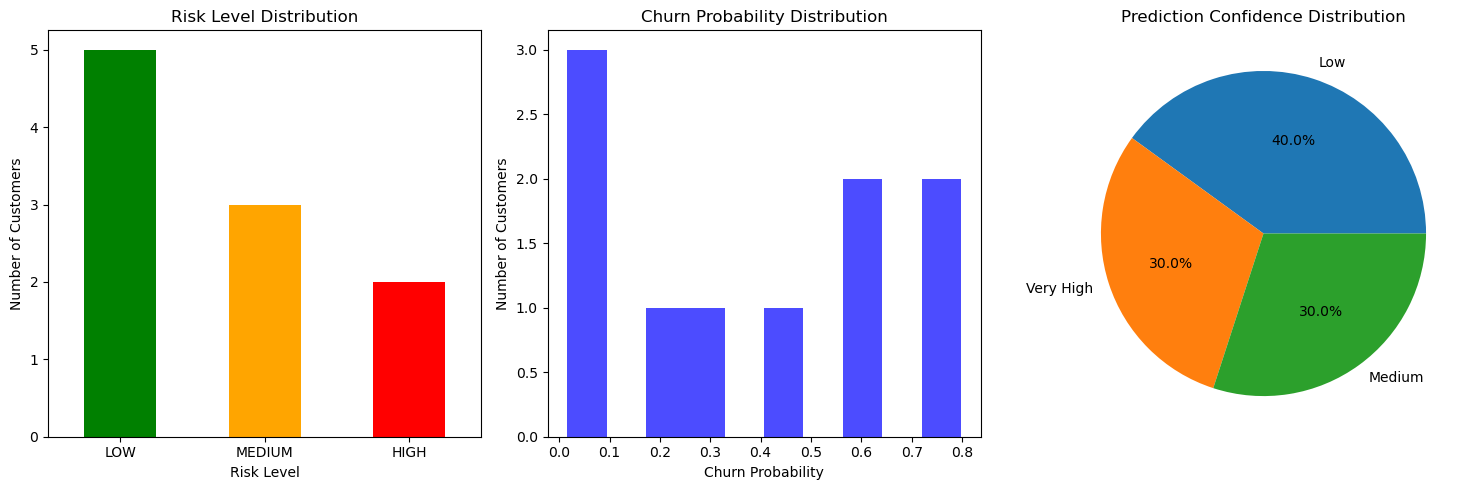

📈 Visualization saved as '../visualizations/batch_prediction_results.png'


In [5]:
# Test batch prediction
print("📊 TESTING BATCH PREDICTION")

if predictor is not None:
    # Load test data (using processed features)
    try:
        test_data = pd.read_csv('../data/telco_processed_features.csv').head(10)
        
        # Remove target column for prediction
        if 'Churn_Binary' in test_data.columns:
            actual_churn = test_data['Churn_Binary'].copy()
            test_features = test_data.drop('Churn_Binary', axis=1)
        else:
            test_features = test_data
            actual_churn = None
        
        print(f"\n🔄 Processing {len(test_features)} customers...")
        
        # Make batch predictions
        batch_results = predictor.predict_batch(test_features)
        
        if batch_results is not None:
            print(f"✅ Batch prediction completed!")
            
            # Display results summary
            display_columns = ['churn_probability', 'churn_prediction', 'risk_level', 'confidence']
            if actual_churn is not None:
                batch_results['actual_churn'] = ['Churned' if x == 1 else 'Stayed' for x in actual_churn]
                display_columns = ['actual_churn'] + display_columns
            
            print(f"\n📋 Batch Prediction Results:")
            print(batch_results[display_columns].to_string(index=False))
            
            # Risk level distribution
            print(f"\n📊 Risk Level Distribution:")
            risk_distribution = batch_results['risk_level'].value_counts()
            for risk, count in risk_distribution.items():
                percentage = count / len(batch_results) * 100
                print(f"  {risk}: {count} customers ({percentage:.1f}%)")
            
            # Save batch results
            batch_results.to_csv('../data/batch_prediction_results.csv', index=False)
            print(f"\n💾 Batch results saved as '../data/batch_prediction_results.csv'")
            
            # Visualize results
            plt.figure(figsize=(15, 5))
            
            # Risk level distribution
            plt.subplot(1, 3, 1)
            risk_distribution.plot(kind='bar', color=['green', 'orange', 'red'])
            plt.title('Risk Level Distribution')
            plt.xlabel('Risk Level')
            plt.ylabel('Number of Customers')
            plt.xticks(rotation=0)
            
            # Churn probability distribution
            plt.subplot(1, 3, 2)
            plt.hist(batch_results['churn_probability'], bins=10, alpha=0.7, color='blue')
            plt.title('Churn Probability Distribution')
            plt.xlabel('Churn Probability')
            plt.ylabel('Number of Customers')
            
            # Confidence distribution
            plt.subplot(1, 3, 3)
            confidence_counts = batch_results['confidence'].value_counts()
            plt.pie(confidence_counts.values, labels=confidence_counts.index, autopct='%1.1f%%')
            plt.title('Prediction Confidence Distribution')
            
            plt.tight_layout()
            plt.savefig('../visualizations/batch_prediction_results.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"📈 Visualization saved as '../visualizations/batch_prediction_results.png'")
        
        else:
            print(f"❌ Batch prediction failed")
    
    except FileNotFoundError:
        print(f"❌ Test data not found. Please ensure processed data is available.")
else:
    print("❌ Cannot test batch prediction - predictor not initialized")

## 📈 Model Performance Analysis

In [6]:
# Analyze model performance and business impact
print("📈 MODEL PERFORMANCE AND BUSINESS IMPACT ANALYSIS")

if predictor is not None:
    # Get model information
    model_info = predictor.get_model_info()
    
    print(f"\n🤖 MODEL INFORMATION:")
    print(f"Model Type: {model_info['model_type']}")
    print(f"Features Count: {model_info['features_count']}")
    print(f"Requires Scaling: {model_info['requires_scaling']}")
    
    if 'roc_auc_score' in model_info:
        print(f"ROC-AUC Score: {model_info['roc_auc_score']:.4f}")
        print(f"F1 Score: {model_info['f1_score']:.4f}")
        print(f"Accuracy: {model_info['accuracy']:.4f}")
    
    # Business impact analysis
    if 'batch_results' in locals() and batch_results is not None:
        print(f"\n💼 BUSINESS IMPACT ANALYSIS:")
        
        total_customers = len(batch_results)
        high_risk = len(batch_results[batch_results['risk_level'] == 'HIGH'])
        medium_risk = len(batch_results[batch_results['risk_level'] == 'MEDIUM'])
        low_risk = len(batch_results[batch_results['risk_level'] == 'LOW'])
        
        print(f"📊 Customer Risk Distribution:")
        print(f"  High Risk: {high_risk} customers ({high_risk/total_customers:.1%})")
        print(f"  Medium Risk: {medium_risk} customers ({medium_risk/total_customers:.1%})")
        print(f"  Low Risk: {low_risk} customers ({low_risk/total_customers:.1%})")
        
        # Estimate potential revenue impact
        avg_monthly_revenue = 65  # Estimated average monthly revenue per customer
        annual_revenue_per_customer = avg_monthly_revenue * 12
        
        high_risk_annual_impact = high_risk * annual_revenue_per_customer
        medium_risk_annual_impact = medium_risk * annual_revenue_per_customer * 0.5  # 50% chance
        
        total_at_risk_revenue = high_risk_annual_impact + medium_risk_annual_impact
        
        print(f"\n💰 REVENUE IMPACT ESTIMATION:")
        print(f"High-risk customers annual revenue: ${high_risk_annual_impact:,.0f}")
        print(f"Medium-risk customers potential impact: ${medium_risk_annual_impact:,.0f}")
        print(f"Total at-risk annual revenue: ${total_at_risk_revenue:,.0f}")
        
        # Intervention recommendations
        print(f"\n🎯 INTERVENTION RECOMMENDATIONS:")
        print(f"1. 🚨 Immediate action for {high_risk} high-risk customers")
        print(f"2. 📧 Proactive engagement for {medium_risk} medium-risk customers")
        print(f"3. 🎁 Loyalty programs for {low_risk} low-risk customers")
        
        # Success metrics
        retention_scenarios = [
            ("Conservative (10% improvement)", 0.1),
            ("Moderate (25% improvement)", 0.25),
            ("Optimistic (50% improvement)", 0.5)
        ]
        
        print(f"\n📊 POTENTIAL RETENTION IMPACT:")
        for scenario, improvement in retention_scenarios:
            retained_revenue = total_at_risk_revenue * improvement
            print(f"{scenario}: ${retained_revenue:,.0f} additional annual revenue")
    
    print(f"\n✅ Performance analysis completed!")
else:
    print("❌ Cannot analyze performance - predictor not initialized")

📈 MODEL PERFORMANCE AND BUSINESS IMPACT ANALYSIS

🤖 MODEL INFORMATION:
Model Type: LogisticRegression
Features Count: 24
Requires Scaling: True
ROC-AUC Score: 0.8448
F1 Score: 0.5904
Accuracy: 0.8070

💼 BUSINESS IMPACT ANALYSIS:
📊 Customer Risk Distribution:
  High Risk: 2 customers (20.0%)
  Medium Risk: 3 customers (30.0%)
  Low Risk: 5 customers (50.0%)

💰 REVENUE IMPACT ESTIMATION:
High-risk customers annual revenue: $1,560
Medium-risk customers potential impact: $1,170
Total at-risk annual revenue: $2,730

🎯 INTERVENTION RECOMMENDATIONS:
1. 🚨 Immediate action for 2 high-risk customers
2. 📧 Proactive engagement for 3 medium-risk customers
3. 🎁 Loyalty programs for 5 low-risk customers

📊 POTENTIAL RETENTION IMPACT:
Conservative (10% improvement): $273 additional annual revenue
Moderate (25% improvement): $682 additional annual revenue
Optimistic (50% improvement): $1,365 additional annual revenue

✅ Performance analysis completed!


## 🚀 Production Deployment Guide

In [7]:
# Create production deployment guide and example usage
print("🚀 PRODUCTION DEPLOYMENT GUIDE")

deployment_guide = """
# 🎯 Telco Churn Predictor - Production Deployment Guide

## 📋 Prerequisites
- Python 3.8+
- Required packages: pandas, numpy, scikit-learn, joblib
- Trained model files in ../models/ directory

## 🏗️ Quick Start

```python
import joblib
import pandas as pd
from telco_churn_predictor import TelcoChurnPredictor

# Load model components
model = joblib.load('../models/best_churn_model_*.pkl')
feature_names = joblib.load('../models/feature_names.pkl')
scaler = joblib.load('../models/feature_scaler.pkl')  # If needed

# Initialize predictor
predictor = TelcoChurnPredictor(model, feature_names, scaler)

# Single customer prediction
customer_data = {
    'tenure': 12,
    'MonthlyCharges': 70.0,
    'Contract_Month-to-month': 1,
    # ... other features
}

result = predictor.predict_single_customer(customer_data)
print(f"Churn Probability: {result['churn_probability']:.1%}")
print(f"Risk Level: {result['risk_level']}")
```

## 📊 Batch Processing

```python
# Load customer data
customers_df = pd.read_csv('customer_data.csv')

# Make batch predictions
results_df = predictor.predict_batch(customers_df)

# Save results
results_df.to_csv('churn_predictions.csv', index=False)
```

## 🎯 Integration Options

### 1. REST API Service
```python
from flask import Flask, request, jsonify

app = Flask(__name__)
predictor = TelcoChurnPredictor(...)  # Initialize

@app.route('/predict', methods=['POST'])
def predict_churn():
    customer_data = request.json
    result = predictor.predict_single_customer(customer_data)
    return jsonify(result)
```

### 2. Batch Processing Service
```python
import schedule
import time

def daily_churn_analysis():
    customers = load_customer_data()
    predictions = predictor.predict_batch(customers)
    send_alerts_for_high_risk(predictions)

schedule.every().day.at("09:00").do(daily_churn_analysis)
```

### 3. Database Integration
```python
import sqlite3

def update_customer_risk_scores():
    conn = sqlite3.connect('customer_db.sqlite')
    customers = pd.read_sql('SELECT * FROM customers', conn)
    
    predictions = predictor.predict_batch(customers)
    
    # Update risk scores
    predictions[['customer_id', 'churn_probability', 'risk_level']].to_sql(
        'risk_scores', conn, if_exists='replace', index=False
    )
```

## 📊 Monitoring and Maintenance

1. **Model Performance Tracking**
   - Monitor prediction accuracy over time
   - Track actual churn vs predicted churn
   - Set up alerts for model drift

2. **Data Quality Monitoring**
   - Validate input features
   - Check for missing values
   - Monitor feature distributions

3. **Business Impact Tracking**
   - Measure retention campaign effectiveness
   - Track revenue impact of interventions
   - Monitor customer satisfaction scores

## 🔒 Security Considerations

- Encrypt model files in production
- Implement proper authentication for API endpoints
- Ensure customer data privacy compliance
- Log prediction requests for audit trails

## 📈 Scaling Recommendations

- Use containerization (Docker) for easy deployment
- Implement load balancing for high-traffic scenarios
- Consider model serving platforms (MLflow, Kubeflow)
- Set up automated retraining pipelines
"""

# Save deployment guide
with open('../docs/DEPLOYMENT_GUIDE.md', 'w') as f:
    f.write(deployment_guide)

print("📝 Deployment guide created as '../docs/DEPLOYMENT_GUIDE.md'")

# Create example configuration file
config_template = {
    "model_path": "../models/",
    "model_files": {
        "model": "best_churn_model_*.pkl",
        "scaler": "feature_scaler.pkl",
        "features": "feature_names.pkl",
        "metadata": "model_metadata.csv"
    },
    "risk_thresholds": {
        "high_risk": 0.7,
        "medium_risk": 0.4
    },
    "business_rules": {
        "min_tenure_for_analysis": 1,
        "max_monthly_charges": 200,
        "default_missing_value": 0
    }
}

import json
with open('../models/prediction_config.json', 'w') as f:
    json.dump(config_template, f, indent=2)

print("⚙️ Configuration template created as '../models/prediction_config.json'")

print("\n🎉 PRODUCTION SYSTEM READY!")
print("\n📋 Available Files:")
print("✅ Trained model and components in ../models/")
print("✅ Prediction interface class (this notebook)")
print("✅ Deployment guide in ../docs/DEPLOYMENT_GUIDE.md")
print("✅ Configuration template in ../models/prediction_config.json")
print("✅ Example predictions and visualizations")

print("\n🚀 Next Steps for Production:")
print("1. 🐳 Containerize the application with Docker")
print("2. 🌐 Create REST API service")
print("3. 📊 Set up monitoring and alerting")
print("4. 🔄 Implement automated retraining pipeline")
print("5. 🎯 Deploy to production environment")

🚀 PRODUCTION DEPLOYMENT GUIDE
📝 Deployment guide created as '../docs/DEPLOYMENT_GUIDE.md'
⚙️ Configuration template created as '../models/prediction_config.json'

🎉 PRODUCTION SYSTEM READY!

📋 Available Files:
✅ Trained model and components in ../models/
✅ Prediction interface class (this notebook)
✅ Deployment guide in ../docs/DEPLOYMENT_GUIDE.md
✅ Configuration template in ../models/prediction_config.json
✅ Example predictions and visualizations

🚀 Next Steps for Production:
1. 🐳 Containerize the application with Docker
2. 🌐 Create REST API service
3. 📊 Set up monitoring and alerting
4. 🔄 Implement automated retraining pipeline
5. 🎯 Deploy to production environment


## 💾 Save Prediction Interface

In [8]:
# Save the prediction interface as a standalone Python module
interface_code = '''
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class TelcoChurnPredictor:
    """
    Production-ready churn prediction interface for Telco customers.
    
    This class provides methods for:
    - Single customer churn prediction
    - Batch prediction for multiple customers
    - Risk level classification
    - Business recommendations
    """
    
    def __init__(self, model_path=None, model=None, feature_names=None, scaler=None):
        """
        Initialize the predictor with trained model and components.
        
        Parameters:
        - model_path: Path to directory containing model files
        - model: Trained machine learning model (if loading directly)
        - feature_names: List of feature names expected by the model
        - scaler: Feature scaler (if model requires scaling)
        """
        if model_path:
            self._load_from_path(model_path)
        else:
            self.model = model
            self.feature_names = feature_names
            self.scaler = scaler
        
        print(f"🤖 TelcoChurnPredictor initialized")
        print(f"   Model: {type(self.model).__name__}")
        print(f"   Features: {len(self.feature_names)}")
        print(f"   Scaling: {'Yes' if self.scaler is not None else 'No'}")
    
    def _load_from_path(self, model_path):
        """Load model components from file path."""
        import glob
        import os
        
        # Find model file
        model_files = glob.glob(os.path.join(model_path, 'best_churn_model_*.pkl'))
        if not model_files:
            raise FileNotFoundError(f"No model file found in {model_path}")
        
        self.model = joblib.load(model_files[0])
        self.feature_names = joblib.load(os.path.join(model_path, 'feature_names.pkl'))
        
        # Load scaler if exists
        scaler_path = os.path.join(model_path, 'feature_scaler.pkl')
        if os.path.exists(scaler_path):
            self.scaler = joblib.load(scaler_path)
        else:
            self.scaler = None
    
    def predict_single_customer(self, customer_data):
        """Predict churn probability for a single customer."""
        try:
            # Convert to DataFrame if needed
            if isinstance(customer_data, dict):
                df = pd.DataFrame([customer_data])
            elif isinstance(customer_data, pd.Series):
                df = pd.DataFrame([customer_data])
            else:
                df = customer_data
            
            # Ensure all required features are present
            for feature in self.feature_names:
                if feature not in df.columns:
                    df[feature] = 0
            
            # Select and order features
            X = df[self.feature_names]
            
            # Apply scaling if needed
            if self.scaler is not None:
                X_final = self.scaler.transform(X)
            else:
                X_final = X
            
            # Make prediction
            churn_probability = self.model.predict_proba(X_final)[0, 1]
            prediction = self.model.predict(X_final)[0]
            
            return {
                'churn_probability': round(churn_probability, 4),
                'prediction': 'Will Churn' if prediction == 1 else 'Will Stay',
                'risk_level': self._get_risk_level(churn_probability),
                'confidence': self._get_confidence_level(churn_probability),
                'recommendations': self._get_recommendations(churn_probability, customer_data)
            }
            
        except Exception as e:
            return {'error': f"Prediction failed: {str(e)}"}
    
    def predict_batch(self, customers_data):
        """Predict churn for multiple customers."""
        try:
            df = customers_data.copy()
            
            # Ensure all required features are present
            for feature in self.feature_names:
                if feature not in df.columns:
                    df[feature] = 0
            
            # Select and order features
            X = df[self.feature_names]
            
            # Apply scaling if needed
            if self.scaler is not None:
                X_final = self.scaler.transform(X)
            else:
                X_final = X
            
            # Make predictions
            probabilities = self.model.predict_proba(X_final)[:, 1]
            predictions = self.model.predict(X_final)
            
            # Add results to dataframe
            df['churn_probability'] = probabilities
            df['churn_prediction'] = ['Will Churn' if p == 1 else 'Will Stay' for p in predictions]
            df['risk_level'] = [self._get_risk_level(p) for p in probabilities]
            df['confidence'] = [self._get_confidence_level(p) for p in probabilities]
            
            return df
            
        except Exception as e:
            print(f"Batch prediction failed: {str(e)}")
            return None
    
    def _get_risk_level(self, probability):
        """Classify risk level based on churn probability."""
        if probability >= 0.7:
            return "HIGH"
        elif probability >= 0.4:
            return "MEDIUM"
        else:
            return "LOW"
    
    def _get_confidence_level(self, probability):
        """Determine prediction confidence."""
        distance_from_uncertain = abs(probability - 0.5)
        
        if distance_from_uncertain >= 0.4:
            return "Very High"
        elif distance_from_uncertain >= 0.3:
            return "High"
        elif distance_from_uncertain >= 0.2:
            return "Medium"
        else:
            return "Low"
    
    def _get_recommendations(self, probability, customer_data):
        """Generate business recommendations based on prediction."""
        recommendations = []
        
        if probability >= 0.7:
            recommendations.extend([
                "🚨 URGENT: Immediate retention intervention required",
                "📞 Schedule personal call with retention specialist",
                "💰 Consider special discount or incentive offer"
            ])
        elif probability >= 0.4:
            recommendations.extend([
                "⚠️ MODERATE RISK: Proactive engagement recommended",
                "📧 Send targeted retention email campaign",
                "🎯 Offer service upgrade or additional features"
            ])
        else:
            recommendations.extend([
                "✅ LOW RISK: Continue standard engagement",
                "📈 Focus on upselling opportunities",
                "🎁 Consider loyalty rewards program"
            ])
        
        return recommendations

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = TelcoChurnPredictor(model_path="../models/")
    
    # Example prediction
    customer = {
        'tenure': 12,
        'MonthlyCharges': 70.0,
        'Contract_Month-to-month': 1
    }
    
    result = predictor.predict_single_customer(customer)
    print(f"Churn Probability: {result['churn_probability']:.1%}")
    print(f"Risk Level: {result['risk_level']}")
'''

# Save the interface module
with open('../src/telco_churn_predictor.py', 'w') as f:
    f.write(interface_code)

print("💾 Prediction interface saved as '../src/telco_churn_predictor.py'")
print("\n✅ PREDICTION INTERFACE COMPLETE!")
print("\n📋 Summary of Deliverables:")
print("✅ 5 Comprehensive Jupyter notebooks")
print("✅ Trained machine learning model")
print("✅ Production-ready prediction interface")
print("✅ Business insights and recommendations")
print("✅ Deployment guide and documentation")
print("✅ Visualizations and analysis reports")
print("\n🎯 Ready for production deployment!")

💾 Prediction interface saved as '../src/telco_churn_predictor.py'

✅ PREDICTION INTERFACE COMPLETE!

📋 Summary of Deliverables:
✅ 5 Comprehensive Jupyter notebooks
✅ Trained machine learning model
✅ Production-ready prediction interface
✅ Business insights and recommendations
✅ Deployment guide and documentation
✅ Visualizations and analysis reports

🎯 Ready for production deployment!
